In [4]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random

def generate_traffic_dataset(n_rows=50000, start_date='2025-01-01', sensor_count=1, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    start = pd.to_datetime(start_date)
    # create timestamps spaced at 5-minute intervals (you can sample intervals later)
    timestamps = [start + timedelta(minutes=5*i) for i in range(n_rows)]
    intervals = np.random.choice(['5min', '15min', '1h'], size=n_rows, p=[0.7,0.25,0.05])
    sensor_ids = np.random.choice([f'sensor_{i+1}' for i in range(sensor_count)], size=n_rows)

    rows = []
    for ts, inter, sid in zip(timestamps, intervals, sensor_ids):
        hour = ts.hour
        # base traffic intensity by hour (rush hours 8-10 and 17-19)
        if 7 <= hour <= 10 or 16 <= hour <= 19:
            base = np.random.poisson(30)
        elif 11 <= hour <= 15:
            base = np.random.poisson(15)
        elif 20 <= hour <= 23:
            base = np.random.poisson(8)
        else:
            base = np.random.poisson(3)

        # generate counts with some class proportions
        cars = max(0, int(base * np.random.uniform(0.6, 1.2)))
        cyclists = max(0, np.random.poisson(base*0.05))
        pedestrians = max(0, int(np.random.poisson(base*0.4 if 11 <= hour <= 14 else base*0.15)))
        vans = max(0, np.random.poisson(base*0.08))
        buses = max(0, np.random.poisson(base*0.03))
        trucks = max(0, np.random.poisson(base*0.04))

        # randomly set route type if you want separate incoming/outgoing/pedestrian rows
        route = np.random.choice(['incoming','outgoing','pedestrian'], p=[0.45,0.45,0.10])
        incoming_total = cars + vans + buses + trucks if route == 'incoming' else max(0, int((cars+vans+buses+trucks)*np.random.uniform(0.6,1.4)))
        outgoing_total = cars + vans + buses + trucks if route == 'outgoing' else max(0, int((cars+vans+buses+trucks)*np.random.uniform(0.6,1.4)))

        vehicle_volume = cars + cyclists + vans + buses + trucks
        net_traffic = incoming_total - outgoing_total

        # dominant class
        class_counts = {'cars':cars, 'cyclists':cyclists, 'pedestrians':pedestrians, 'vans':vans, 'buses':buses, 'trucks':trucks}
        dominant_class = max(class_counts, key=class_counts.get)

        rows.append({
            'timestamp': ts,
            'interval': inter,
            'route': route,
            'cars': cars,
            'cyclists': cyclists,
            'pedestrians': pedestrians,
            'vans': vans,
            'buses': buses,
            'trucks': trucks,
            'incoming_total': incoming_total,
            'outgoing_total': outgoing_total,
            'vehicle_volume': vehicle_volume,
            'net_traffic': net_traffic,
            'dominant_class': dominant_class,
            'day_of_week': ts.weekday(),
            'hour': ts.hour,
            'is_weekend': ts.weekday()>=5,
            'sensor_id': sid
        })

    df = pd.DataFrame(rows)
    return df



In [5]:

df = generate_traffic_dataset(n_rows=20000, start_date='2025-01-01', sensor_count=2)
df.to_csv('traffic_synthetic.csv', index=False)


In [6]:
df=pd.read_csv("traffic_synthetic.csv")

In [7]:
df.head()

,timestamp,interval,route,cars,cyclists,pedestrians,vans,buses,trucks,incoming_total,outgoing_total,vehicle_volume,net_traffic,dominant_class,day_of_week,hour,is_weekend,sensor_id
0,2025-01-01 00:00:00,5min,incoming,4,1,1,0,1,0,5,6,6,-1,cars,2,0,False,sensor_2
1,2025-01-01 00:05:00,1h,outgoing,0,0,0,0,0,0,0,0,0,0,cars,2,0,False,sensor_2
2,2025-01-01 00:10:00,15min,pedestrian,3,0,0,0,0,0,3,4,3,-1,cars,2,0,False,sensor_2
3,2025-01-01 00:15:00,5min,incoming,1,0,0,0,0,0,1,1,1,0,cars,2,0,False,sensor_1
4,2025-01-01 00:20:00,5min,outgoing,4,0,1,1,0,0,5,5,5,0,cars,2,0,False,sensor_1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       20000 non-null  object
 1   interval        20000 non-null  object
 2   route           20000 non-null  object
 3   cars            20000 non-null  int64 
 4   cyclists        20000 non-null  int64 
 5   pedestrians     20000 non-null  int64 
 6   vans            20000 non-null  int64 
 7   buses           20000 non-null  int64 
 8   trucks          20000 non-null  int64 
 9   incoming_total  20000 non-null  int64 
 10  outgoing_total  20000 non-null  int64 
 11  vehicle_volume  20000 non-null  int64 
 12  net_traffic     20000 non-null  int64 
 13  dominant_class  20000 non-null  object
 14  day_of_week     20000 non-null  int64 
 15  hour            20000 non-null  int64 
 16  is_weekend      20000 non-null  bool  
 17  sensor_id       20000 non-null  object
dtypes: boo

In [9]:
df.isnull().sum()

timestamp         0
interval          0
route             0
cars              0
cyclists          0
pedestrians       0
vans              0
buses             0
trucks            0
incoming_total    0
outgoing_total    0
vehicle_volume    0
net_traffic       0
dominant_class    0
day_of_week       0
hour              0
is_weekend        0
sensor_id         0
dtype: int64

In [10]:
df.describe()

,cars,cyclists,pedestrians,vans,buses,trucks,incoming_total,outgoing_total,vehicle_volume,net_traffic,day_of_week,hour
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,13.289050,0.762000,2.902400,1.236250,0.464650,0.607650,15.344950,15.311350,16.359600,0.033600,3.016000,11.457400
std,11.174213,1.061043,2.856096,1.464119,0.768036,0.901417,13.424186,13.379655,13.571098,4.924427,1.999986,6.924954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-33.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,-2.000000,1.000000,5.000000
50%,10.000000,0.000000,2.000000,1.000000,0.000000,0.000000,12.000000,12.000000,13.000000,0.000000,3.000000,11.000000
75%,22.000000,1.000000,5.000000,2.000000,1.000000,1.000000,25.000000,25.000000,27.000000,2.000000,5.000000,17.000000
max,61.000000,9.000000,22.000000,10.000000,7.000000,7.000000,72.000000,75.000000,74.000000,31.000000,6.000000,23.000000


### Data Cleaning

In [11]:
# Missing value treatment

count_columns=['cars','cyclists','pedestrians','vans','buses','trucks','incoming_total','outgoing_total']

In [12]:
df[count_columns] = df[count_columns].fillna(0)
df['interval']= df['interval'].fillna(df['interval'].mode()[0])
df['route'] = df['route'].fillna(df['route'].mode()[0])

In [13]:
## Remove duplicates
df=df.drop_duplicates(subset=['timestamp','route','sensor_id'])

In [14]:
## Mark outliers
for col in count_columns:
    df[f'outlier_{col}'] = np.where(df[col]>df[col].quantile(0.99),1,0)

### Data Reshaping

In [15]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [16]:
## Feature Engineering
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.weekday
df['is_weekend'] = df['day_of_week'] >= 5

df['vehicle_volume']= df[['cars','cyclists','pedestrians','vans','buses','trucks',]].sum(axis=1)
df['net_traffic']= df['incoming_total'] +df['outgoing_total']

In [17]:
## convert interval into numerical minutes
interval_map= {"5min":5,"15min":15,"1h":60,"1d":1440}
df['interval_min'] = df['interval'].map(interval_map)

In [18]:
## Dominate class target
vehicle_cols=['cars','cyclists','pedestrians','vans','buses','trucks']
df['dominant_class'] = df[vehicle_cols].idxmax(1)

### Transformation

In [19]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split

In [20]:
## Encode categorical 
le = LabelEncoder()
df['route_enc'] = le.fit_transform(df['route'])
df['interval_enc'] = le.fit_transform(df['interval'])
df['sensor_enc'] = le.fit_transform(df['sensor_id'])
df['targat_enc'] = le.fit_transform(df['dominant_class'])

In [21]:
## Feature_columns
feature_cols = [
    'cars','cyclists','pedestrians','vans','buses','trucks',
    'incoming_total','outgoing_total','vehicle_volume','net_traffic',
    'hour','day_of_week','interval_min','route_enc','sensor_enc'
]

In [22]:
x= df[feature_cols]
y = df['targat_enc']

In [23]:
## Scaling
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

### Data Resizing : Train/test split
* time-series aware

In [24]:
df =df.sort_values('timestamp')

In [25]:
split_index=int(len(df)*0.80)
x_train=x_scaled[:split_index]
x_test=x_scaled[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

In [26]:
print("Training Samples :" ,len(x_train))
print("Testing sample :", len(x_test))
print("classes :",df['dominant_class'].unique())

Training Samples : 16000
Testing sample : 4000
classes : ['cars' 'vans' 'pedestrians' 'trucks' 'cyclists' 'buses']


### Data Visualization

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt


In [28]:
## Categorical Summary
df['dominant_class'].value_counts()

dominant_class
cars           19671
pedestrians      189
vans              67
cyclists          42
trucks            17
buses             14
Name: count, dtype: int64

In [29]:
df['route'].value_counts()

route
incoming      9034
outgoing      8963
pedestrian    2003
Name: count, dtype: int64

In [30]:
df['interval'].value_counts()

interval
5min     14041
15min     4960
1h         999
Name: count, dtype: int64

#### EDA Visualization

In [31]:
sns.set(style='whitegrid')

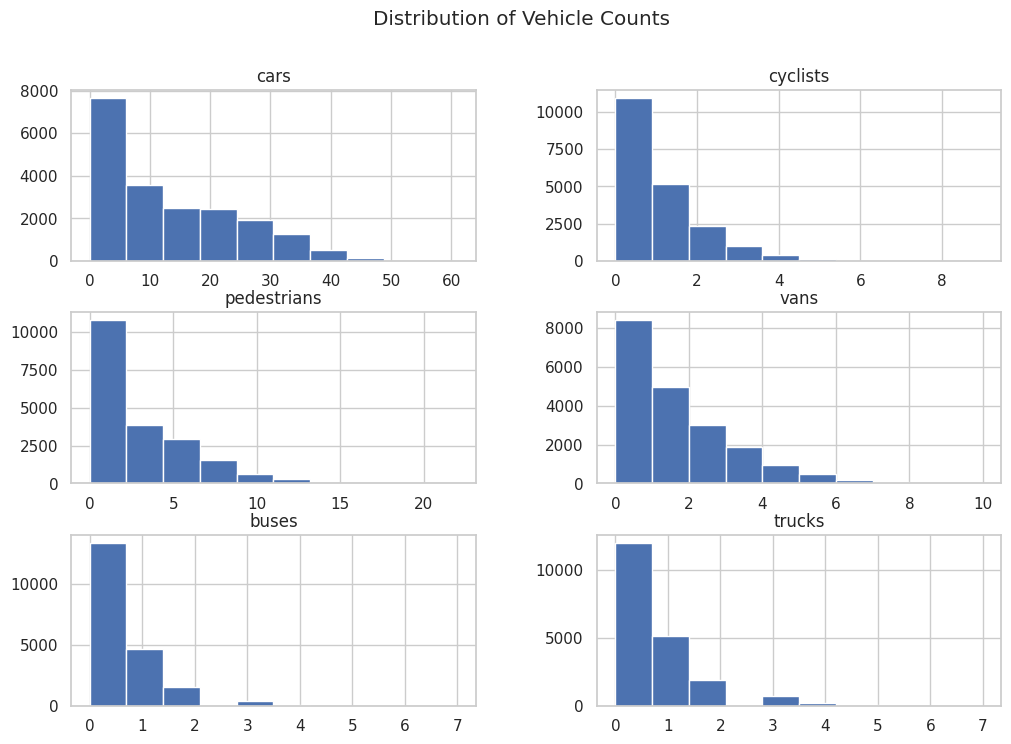

In [32]:
## Vehicle count distributions
vehicle_cols = ['cars','cyclists','pedestrians','vans','buses','trucks']
df[vehicle_cols].hist(figsize=(12,8))
plt.suptitle("Distribution of Vehicle Counts")
plt.show()

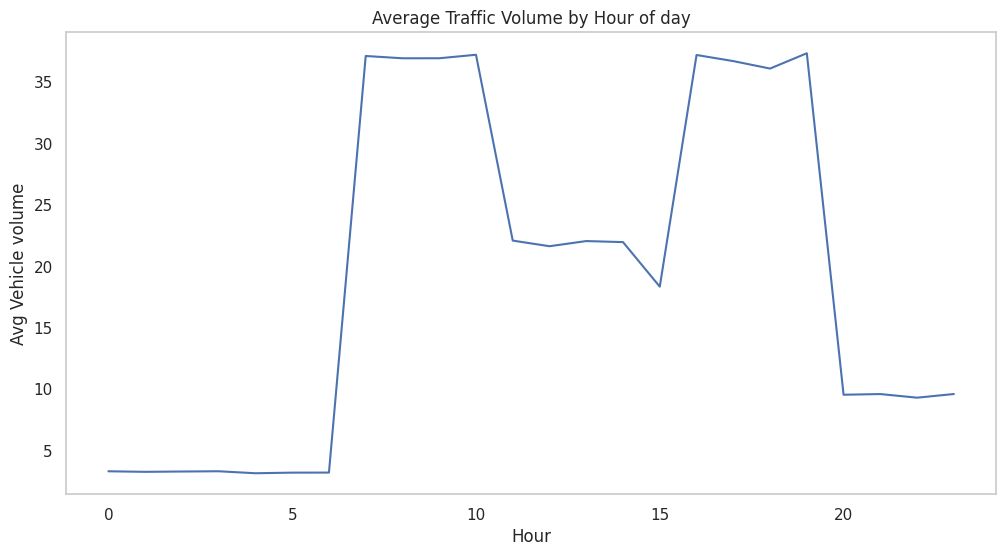

In [33]:
## Hourly traffic pattern (vehicle_volume)
plt.figure(figsize=(12,6))
df.groupby("hour")['vehicle_volume'].mean().plot()
plt.title("Average Traffic Volume by Hour of day")
plt.xlabel("Hour")
plt.ylabel("Avg Vehicle volume")
plt.grid()
plt.show()

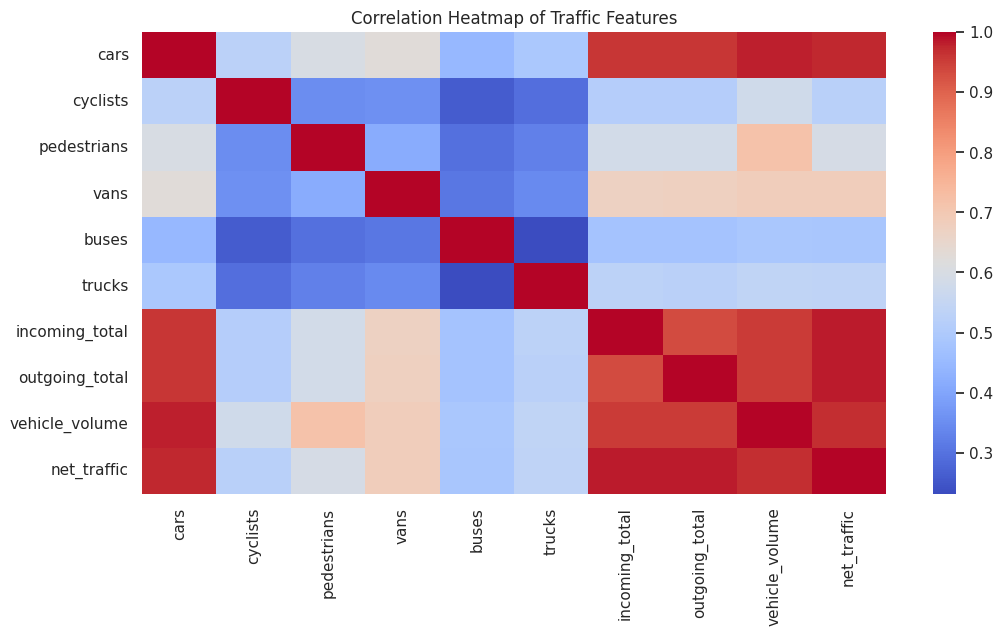

In [34]:
## Correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df[vehicle_cols + ['incoming_total','outgoing_total','vehicle_volume','net_traffic']].corr(),
            annot=False,cmap='coolwarm')
plt.title("Correlation Heatmap of Traffic Features")
plt.show()

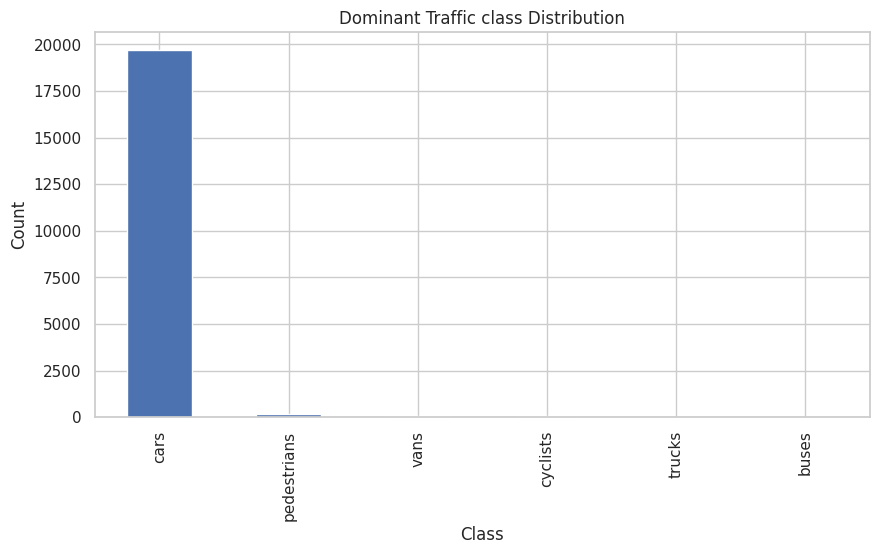

In [35]:
## Dominant class distribution
plt.figure(figsize=(10,5))
df['dominant_class'].value_counts().plot(kind='bar')
plt.title("Dominant Traffic class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

<Figure size 1200x600 with 0 Axes>

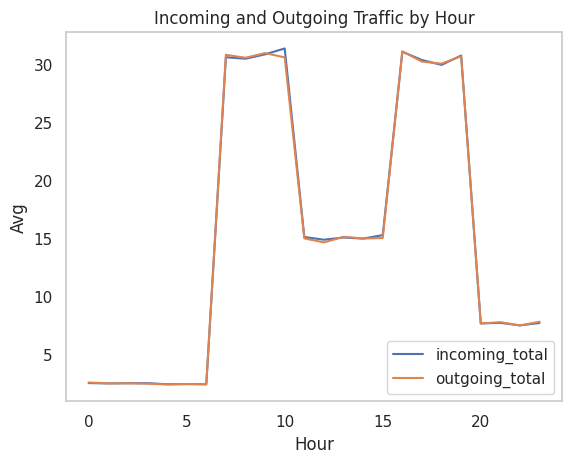

In [36]:
## Incoming vs outgoing volume comarison
plt.figure(figsize=(12,6))
df.groupby("hour")[['incoming_total','outgoing_total']].mean().plot()
plt.title("Incoming and Outgoing Traffic by Hour")
plt.xlabel("Hour")
plt.ylabel("Avg")
plt.grid()
plt.show()

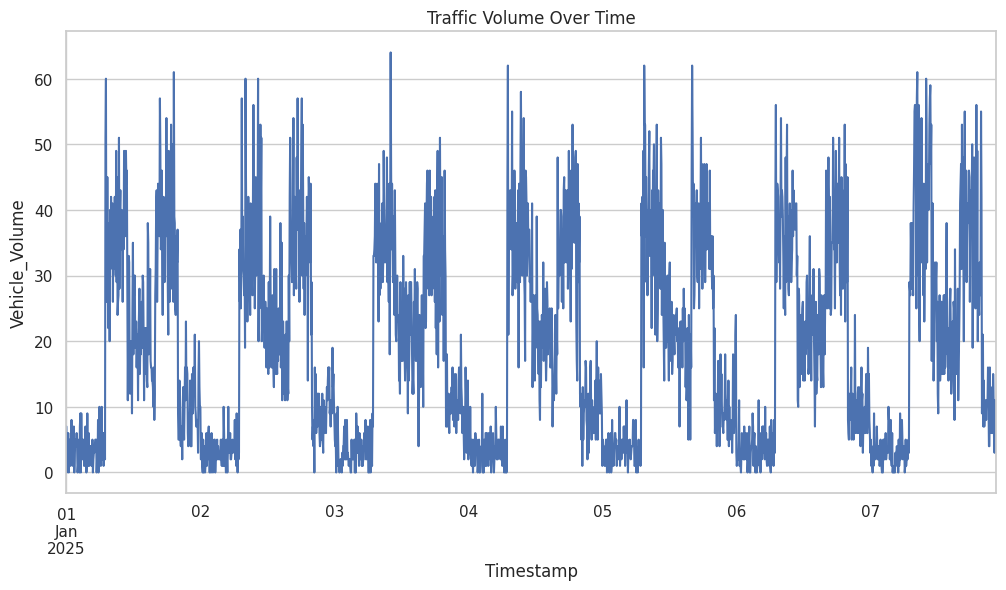

In [37]:
## Time-series traffic volume
plt.figure(figsize=(12,6))
df.set_index('timestamp')['vehicle_volume'].head(2000).plot()
plt.title("Traffic Volume Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Vehicle_Volume")
plt.show()

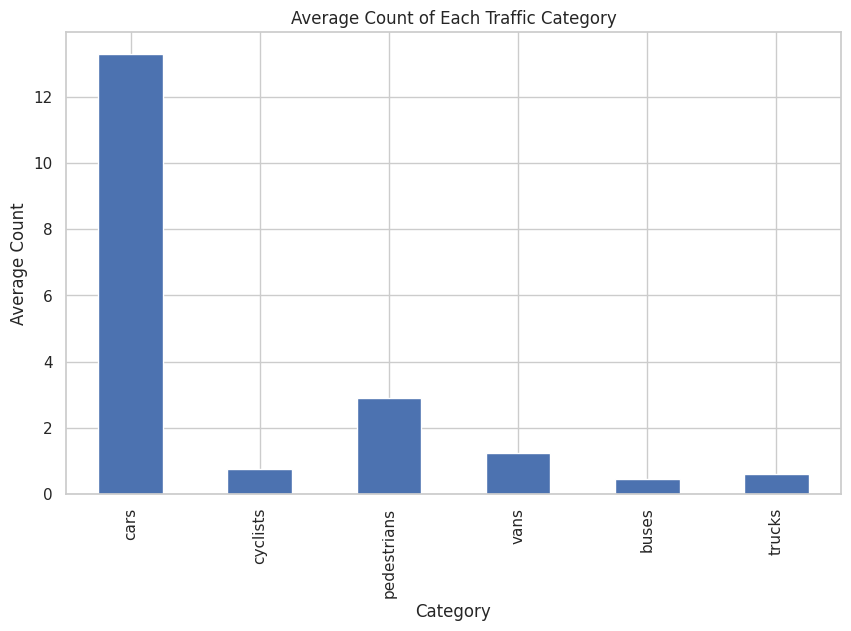

In [38]:
##6 Traffic Composition
plt.figure(figsize=(10,6))
df[['cars','cyclists','pedestrians','vans','buses','trucks']].mean().plot(kind='bar')
plt.title("Average Count of Each Traffic Category")
plt.xlabel("Category")
plt.ylabel("Average Count")
plt.show()

### Training Machine Learning Model

In [39]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [40]:
x=df[feature_cols]
y=df['vehicle_volume']

#### Train / Valid / Test split

In [41]:
n=len(df)
train_end_reg=int(0.70*n)
valid_end_reg = int(0.80*n)

x_train_reg=x.iloc[:train_end_reg]
y_train_reg=y.iloc[:train_end_reg]

x_valid_reg =x.iloc[train_end_reg:valid_end_reg]
y_valid_reg =y.iloc[train_end_reg:valid_end_reg]

x_test_reg=x.iloc[valid_end_reg:]
y_test_reg=y.iloc[valid_end_reg:]

In [42]:
## Model Definitions
reg_models= {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=150,
        max_depth=20,
        random_state=42
    ),
    "Gradient Boosting":GradientBoostingRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=5,
        random_state=43
    )
}

In [43]:
### train & validate model

result ={}

for name_reg, Model in reg_models.items():
    Model.fit(x_train_reg,y_train_reg)
    preds_reg = Model.predict(x_valid_reg)
    
    mae = mean_absolute_error(y_valid_reg,preds_reg)
    rmse=np.sqrt(mean_squared_error(y_valid_reg,preds_reg))
    r2=r2_score(y_valid_reg,preds_reg)
    
    result[name_reg] = (mae,rmse,r2)
    print(f"\n{name_reg} Validation Results:")
    print(f" MAE : {mae:.4f}")
    print(f" RMSE: {rmse:.4f}")
    print(f" R²  : {r2:.4f}")



Linear Regression Validation Results:
 MAE : 0.0000
 RMSE: 0.0000
 R²  : 1.0000

Random Forest Validation Results:
 MAE : 0.0023
 RMSE: 0.0948
 R²  : 1.0000

Gradient Boosting Validation Results:
 MAE : 0.0082
 RMSE: 0.0906
 R²  : 1.0000


In [44]:
## final test Evaluation(Best model)
best_model_name=max(result,key=lambda k: result[k][2])
best_model = reg_models[best_model_name]

print(f'\nBest Model Selection : {best_model_name}')

test_preds_reg=best_model.predict(x_test_reg)

test_mae=mean_absolute_error(y_test_reg,test_preds_reg)
test_rmse = np.sqrt(mean_squared_error(y_test_reg,test_preds_reg))
test_r2 = r2_score(y_test_reg,test_preds_reg)

print("\n--- Final Test Set Evaluation ---")
print(" MAE :", test_mae)
print(" RMSE:", test_rmse)
print(" R²  :", test_r2)


Best Model Selection : Linear Regression

--- Final Test Set Evaluation ---
 MAE : 4.318385615766052e-15
 RMSE: 6.16759381996287e-15
 R²  : 1.0


### Classification Based Problem

In [45]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [46]:
le= LabelEncoder()
df['targat_enc']=le.fit_transform(df['dominant_class'])

In [50]:
n=len(df)
train_end_cls=int(0.70*n)
valid_end_cls=int(0.85*n)

x_train_cls=x.iloc[:train_end_cls]
y_train_cls=y.iloc[:train_end_cls]

x_valid_cls=x.iloc[train_end_cls:valid_end_cls]
y_valid_cls=y.iloc[train_end_cls:valid_end_cls]

x_text_cls=x.iloc[valid_end_cls:]
y_test_cls=y[valid_end_cls:]

In [51]:
cls_model={
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced",),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        class_weight="balanced",
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [52]:
for name, model in cls_model.items():
    model.fit(x_train_cls, y_train_cls)
    preds_cls = model.predict(x_valid_cls)

    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_valid_cls, preds_cls))
    print(classification_report(y_valid_cls, preds_cls))


/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs


Logistic Regression Results:
Accuracy: 0.19033333333333333
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       107
           1       0.66      0.55      0.60       129
           2       0.43      0.44      0.44       149
           3       0.38      0.45      0.41       143
           4       0.19      0.05      0.08       134
           5       0.24      0.40      0.30       131
           6       0.14      0.09      0.11        99
           7       0.30      0.20      0.24        99
           8       0.21      0.20      0.21        81
           9       0.28      0.14      0.18        80
          10       0.10      0.20      0.13        51
          11       0.18      0.15      0.17        65
          12       0.24      0.18      0.21        67
          13       0.13      0.21      0.16        47
          14       0.00      0.00      0.00        45
          15       0.20      0.21      0.20        48
          16       0.

/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f


Gradient Boosting Results:
Accuracy: 0.9996666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       107
           1       1.00      1.00      1.00       129
           2       1.00      1.00      1.00       149
           3       1.00      1.00      1.00       143
           4       1.00      1.00      1.00       134
           5       1.00      1.00      1.00       131
           6       1.00      1.00      1.00        99
           7       1.00      1.00      1.00        99
           8       1.00      1.00      1.00        81
           9       1.00      1.00      1.00        80
          10       1.00      1.00      1.00        51
          11       1.00      1.00      1.00        65
          12       1.00      1.00      1.00        67
          13       1.00      1.00      1.00        47
          14       1.00      1.00      1.00        45
          15       1.00      1.00      1.00        48
          16       1.00 

/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [53]:
best_model_cls=cls_model["Gradient Boosting"]

In [54]:
test_preds_cls= best_model_cls.predict(x_text_cls)

print(f"\n Final test result \naccuracy: {accuracy_score(y_test_cls,test_preds_cls)}")
print(f"\nClassification Report: \n{classification_report(y_test_cls,test_preds_cls)}")


 Final test result 
accuracy: 0.999

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       124
           1       1.00      1.00      1.00       124
           2       1.00      1.00      1.00       181
           3       1.00      1.00      1.00       161
           4       1.00      1.00      1.00       153
           5       1.00      1.00      1.00       113
           6       1.00      1.00      1.00        82
           7       1.00      1.00      1.00        84
           8       1.00      1.00      1.00        73
           9       1.00      1.00      1.00        67
          10       1.00      1.00      1.00        63
          11       1.00      1.00      1.00        52
          12       1.00      1.00      1.00        56
          13       1.00      1.00      1.00        53
          14       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        51
          16       

/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [55]:
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test_cls,test_preds_cls)}")


Confusion Matrix:
[[124   0   0 ...   0   0   0]
 [  0 124   0 ...   0   0   0]
 [  0   0 181 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   1   0   0]]


### Evaluate different model
### Detect or accuracy of the model

### Regression Model Evaluation

In [56]:
### train & validate model

result ={}

for name_reg, Model in reg_models.items():
    Model.fit(x_train_reg,y_train_reg)
    preds_reg = Model.predict(x_valid_reg)
    
    mae = mean_absolute_error(y_valid_reg,preds_reg)
    rmse=np.sqrt(mean_squared_error(y_valid_reg,preds_reg))
    r2=r2_score(y_valid_reg,preds_reg)
    
    result[name_reg] = (mae,rmse,r2)
    print(f"\n{name_reg} Validation Results:")
    print(f" MAE : {mae:.4f}")
    print(f" RMSE: {rmse:.4f}")
    print(f" R²  : {r2:.4f}")



Linear Regression Validation Results:
 MAE : 0.0000
 RMSE: 0.0000
 R²  : 1.0000

Random Forest Validation Results:
 MAE : 0.0023
 RMSE: 0.0948
 R²  : 1.0000

Gradient Boosting Validation Results:
 MAE : 0.0082
 RMSE: 0.0906
 R²  : 1.0000


In [57]:
## final test Evaluation(Best model)
best_model_name=max(result,key=lambda k: result[k][2])
best_model = reg_models[best_model_name]

print(f'\nBest Model Selection : {best_model_name}')

test_preds_reg=best_model.predict(x_test_reg)

test_mae=mean_absolute_error(y_test_reg,test_preds_reg)
test_rmse = np.sqrt(mean_squared_error(y_test_reg,test_preds_reg))
test_r2 = r2_score(y_test_reg,test_preds_reg)

print("\n--- Final Test Set Evaluation ---")
print(" MAE :", test_mae)
print(" RMSE:", test_rmse)
print(" R²  :", test_r2)


Best Model Selection : Linear Regression

--- Final Test Set Evaluation ---
 MAE : 4.318385615766052e-15
 RMSE: 6.16759381996287e-15
 R²  : 1.0


## Classification Models

#### Model Evaluation

In [58]:
for name, model in cls_model.items():
    model.fit(x_train_cls, y_train_cls)
    preds_cls = model.predict(x_valid_cls)

    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_valid_cls, preds_cls))
    print(classification_report(y_valid_cls, preds_cls))


/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs


Logistic Regression Results:
Accuracy: 0.19033333333333333
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       107
           1       0.66      0.55      0.60       129
           2       0.43      0.44      0.44       149
           3       0.38      0.45      0.41       143
           4       0.19      0.05      0.08       134
           5       0.24      0.40      0.30       131
           6       0.14      0.09      0.11        99
           7       0.30      0.20      0.24        99
           8       0.21      0.20      0.21        81
           9       0.28      0.14      0.18        80
          10       0.10      0.20      0.13        51
          11       0.18      0.15      0.17        65
          12       0.24      0.18      0.21        67
          13       0.13      0.21      0.16        47
          14       0.00      0.00      0.00        45
          15       0.20      0.21      0.20        48
          16       0.

/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f


Gradient Boosting Results:
Accuracy: 0.9996666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       107
           1       1.00      1.00      1.00       129
           2       1.00      1.00      1.00       149
           3       1.00      1.00      1.00       143
           4       1.00      1.00      1.00       134
           5       1.00      1.00      1.00       131
           6       1.00      1.00      1.00        99
           7       1.00      1.00      1.00        99
           8       1.00      1.00      1.00        81
           9       1.00      1.00      1.00        80
          10       1.00      1.00      1.00        51
          11       1.00      1.00      1.00        65
          12       1.00      1.00      1.00        67
          13       1.00      1.00      1.00        47
          14       1.00      1.00      1.00        45
          15       1.00      1.00      1.00        48
          16       1.00 

/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

#### Best model and Final Evaluation

In [59]:
best_model_cls=cls_model["Gradient Boosting"]
test_preds_cls= best_model_cls.predict(x_text_cls)

print(f"\n Final test result \naccuracy: {accuracy_score(y_test_cls,test_preds_cls)}")
print(f"\nClassification Report: \n{classification_report(y_test_cls,test_preds_cls)}")



 Final test result 
accuracy: 0.999

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       124
           1       1.00      1.00      1.00       124
           2       1.00      1.00      1.00       181
           3       1.00      1.00      1.00       161
           4       1.00      1.00      1.00       153
           5       1.00      1.00      1.00       113
           6       1.00      1.00      1.00        82
           7       1.00      1.00      1.00        84
           8       1.00      1.00      1.00        73
           9       1.00      1.00      1.00        67
          10       1.00      1.00      1.00        63
          11       1.00      1.00      1.00        52
          12       1.00      1.00      1.00        56
          13       1.00      1.00      1.00        53
          14       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        51
          16       

/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sheshpalsingh/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [60]:
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test_cls,test_preds_cls)}")


Confusion Matrix:
[[124   0   0 ...   0   0   0]
 [  0 124   0 ...   0   0   0]
 [  0   0 181 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   1   0   0]]
